In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [2]:
import torch
import math
import numpy
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
import itertools
import scipy.stats
import scipy
import random
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
mix = torch.distributions.categorical.Categorical(torch.ones(2))
compo = torch.distributions.von_mises.VonMises(torch.tensor([-2.5,2.5]), torch.tensor([6,6]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(mix, compo)
#p_x = torch.distributions.von_mises.VonMises(0,2)

#Training parameters
N_EPOCHS = 2000
N_SAMPLES = 5000
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

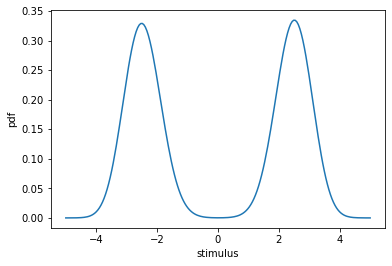

In [4]:
#probability density distribution
plot_pdf(x_samples)

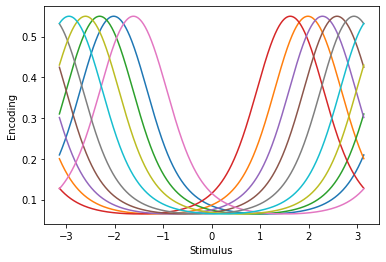

In [27]:
#CIRCULAR ENCODER
enc_circ = CircularBernoulliEncoder(N,x_sorted)
dec = MLPDecoder_circ(N,200)
r = enc_circ.sample(x_fine,100)

plot_enc(enc_circ,x_fine)

FULL TRAINING

In [6]:
#Definition of the loss elements
q = rate_ising(N)
rate = q(enc_circ,x_sorted)
dist = distortion_circular(x_sorted,enc_circ,dec)

In [7]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(dec.parameters(), enc_circ.parameters(), q.parameters())
lr = 1e-4
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
elboVec = []
beta = 0
for epoch in range(N_EPOCHS):
   if beta < 1:
      beta += 6/N_EPOCHS
   for x_ in x_data:
      rate = q(enc_circ,x_)
      dist = distortion_circular(x_,enc_circ,dec)
      loss = dist + beta*rate 
      elbo = dist + rate
      opt.zero_grad()
      loss.backward()
      opt.step()
   lossVec.append(loss.item())
   rateVec.append(rate.item())
   distVec.append(dist.item())
   elboVec.append(elbo.item())

In [8]:
min(lossVec) #enc trained

0.7875227928161621

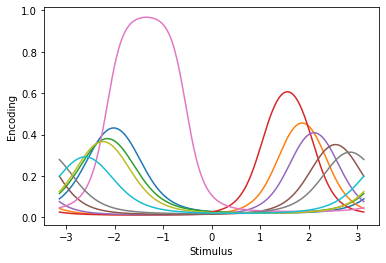

In [22]:
#ENCODING
plot_enc(enc_circ, x_fine)

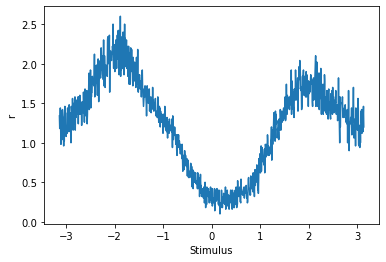

In [23]:
#neurons activity through stimulus space
plot_r(enc_circ, x_fine)

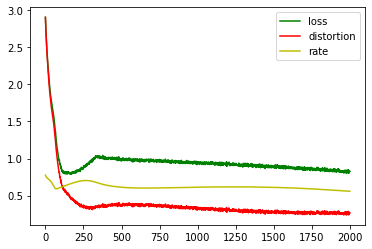

In [11]:
#LOSS
plot_loss(lossVec, distVec, rateVec)

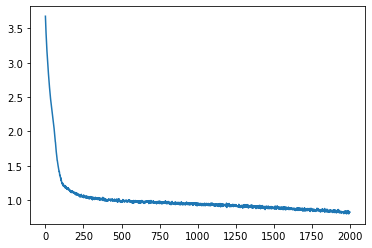

In [21]:
plt.plot(elboVec)

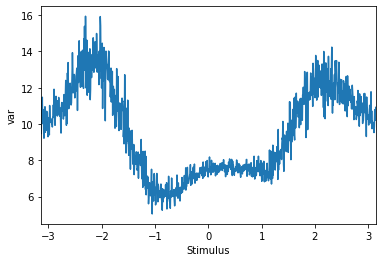

In [24]:
#DECODING

#variance of the decoder through the stimulus space
plot_var_dec(enc_circ, dec, x_fine)


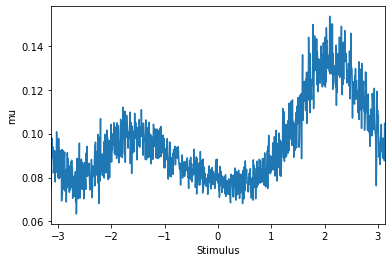

In [31]:
#decoder mu through stimulus space

plot_mu_dec(enc_circ,dec,x_fine)

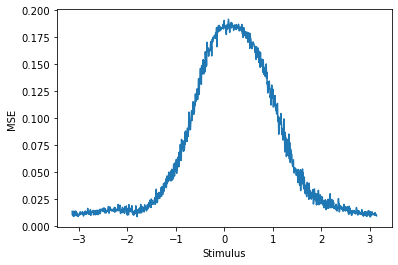

In [26]:
#Mean squared error
plot_mse(enc_circ, dec, x_fine)

In [18]:
x_samples=generative_model(q,dec)

Text(0, 0.5, 'pdf')

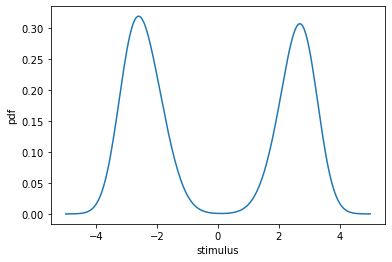

In [19]:
kde = scipy.stats.gaussian_kde(x_samples)
t_range = np.linspace(-5,5,200)
plt.plot(t_range,kde(t_range))
plt.xlabel("stimulus")
plt.ylabel("pdf")

#TRAINING THE ENCODER